# Импорт необходимых библиотек

In [1]:
pip install geopandas

In [2]:
import pandas as pd
import geopandas as gpd
import folium
import folium.plugins
from pyproj import Transformer
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt


**Скачиваем нужные csv-файлы с github**

In [3]:
if not os.path.exists('../data'): os.mkdir("../data")

!curl -o ../data/geo_data.csv https://raw.githubusercontent.com/NoxNokas/HomeWork/main/data/geo_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2980k  100 2980k    0     0  7720k      0 --:--:-- --:--:-- --:--:-- 7740k


## Суть задания:

Необходимо прочитать .csv "test.csv" в котором записаны геоданные (информация в заголовках) в системе координат `source` (нужно будет с помощью pyproj перевести в `target` для отображения на карте с помощью библиотеки folium). Предвартельно нужно будет преобразовать df в формат geopandas.

Нужно выяснить сколько было различных проездов автомобиля (прерывания более 0.5 секунды), визуализировать эти маршруты, визуализировать графики скорости проездов.

In [4]:
source = "EPSG:32637"
target = "EPSG:4326"

In [5]:
data = gpd.read_file("/data/geo_data.csv", encoding='utf-8', crs=source)

In [6]:
data.head()

,field_1,panoram stream number,frame name,GPS time,X,Y,Z,roll,pitch,heading,date time,geometry
0,0,36,ladybug_panoramic_000000,372238.374093,399070.538384,6186248.863528,177.289079,178.355788,178.465146,13.182995,2020-11-12 07:23:58,None
1,1,36,ladybug_panoramic_000001,372238.874115,399072.484287,6186257.807541,177.252496,178.469506,178.115046,13.246203,2020-11-12 07:23:58,None
2,2,36,ladybug_panoramic_000002,372239.374138,399074.43753,6186266.884536,177.218097,178.502584,178.319568,13.085446,2020-11-12 07:23:59,None
3,3,36,ladybug_panoramic_000003,372239.87416,399076.386642,6186276.058376,177.172916,178.456564,177.944437,12.959536,2020-11-12 07:23:59,None
4,4,36,ladybug_panoramic_000004,372240.374182,399078.315928,6186285.339778,177.127745,178.859275,178.618339,12.458477,2020-11-12 07:24:00,None


In [7]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21817 entries, 0 to 21816
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   field_1                21817 non-null  object  
 1   panoram stream number  21817 non-null  object  
 2   frame name             21817 non-null  object  
 3   GPS time               21817 non-null  object  
 4   X                      21817 non-null  object  
 5   Y                      21817 non-null  object  
 6   Z                      21817 non-null  object  
 7   roll                   21817 non-null  object  
 8   pitch                  21817 non-null  object  
 9   heading                21817 non-null  object  
 10  date time              21817 non-null  object  
 11  geometry               0 non-null      geometry
dtypes: geometry(1), object(11)
memory usage: 2.0+ MB


Приведём все object поля к своим типам данных (а заодно и уменьшим размер GeoDataFrame):

In [8]:
data["field_1"] = data['field_1'].astype('int16')
data["panoram stream number"] = data['panoram stream number'].astype('int16')
data["GPS time"] = data['GPS time'].astype('float64')
data["X"] = data['X'].astype('float64')
data["Y"] = data['Y'].astype('float64')
data["Z"] = data['Z'].astype('float64')
data["roll"] = data['roll'].astype('float64')
data["pitch"] = data['pitch'].astype('float64')
data["heading"] = data['heading'].astype('float64')
data["date time"] = data['date time'].astype('datetime64')

data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21817 entries, 0 to 21816
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   field_1                21817 non-null  int16         
 1   panoram stream number  21817 non-null  int16         
 2   frame name             21817 non-null  object        
 3   GPS time               21817 non-null  float64       
 4   X                      21817 non-null  float64       
 5   Y                      21817 non-null  float64       
 6   Z                      21817 non-null  float64       
 7   roll                   21817 non-null  float64       
 8   pitch                  21817 non-null  float64       
 9   heading                21817 non-null  float64       
 10  date time              21817 non-null  datetime64[ns]
 11  geometry               0 non-null      geometry      
dtypes: datetime64[ns](1), float64(7), geometry(1), int16

Добавим геометрию

In [9]:
geometry = gpd.points_from_xy(x=data["X"], y=data["Y"])
data["geometry"] = geometry
data.head()

,field_1,panoram stream number,frame name,GPS time,X,Y,Z,roll,pitch,heading,date time,geometry
0,0,36,ladybug_panoramic_000000,372238.374093,399070.538384,6.186249e+06,177.289079,178.355788,178.465146,13.182995,2020-11-12 07:23:58,POINT (399070.538 6186248.864)
1,1,36,ladybug_panoramic_000001,372238.874115,399072.484287,6.186258e+06,177.252496,178.469506,178.115046,13.246203,2020-11-12 07:23:58,POINT (399072.484 6186257.808)
2,2,36,ladybug_panoramic_000002,372239.374138,399074.437530,6.186267e+06,177.218097,178.502584,178.319568,13.085446,2020-11-12 07:23:59,POINT (399074.438 6186266.885)
3,3,36,ladybug_panoramic_000003,372239.874160,399076.386642,6.186276e+06,177.172916,178.456564,177.944437,12.959536,2020-11-12 07:23:59,POINT (399076.387 6186276.058)
4,4,36,ladybug_panoramic_000004,372240.374182,399078.315928,6.186285e+06,177.127745,178.859275,178.618339,12.458477,2020-11-12 07:24:00,POINT (399078.316 6186285.340)


Найдём точки разрыва (время между соседними замерами больше 1 секунды)

In [10]:
break_time = 1
break_points = data["GPS time"].diff().drop(index=0)
break_points = break_points[break_points > break_time]
break_points

62       104.632798
5335     384.162137
7947     362.087375
8794     144.803908
9270     333.972843
11053     11.067738
12924    636.872752
13384    595.205839
16044     53.176227
19444    356.616845
Name: GPS time, dtype: float64

с помощью класса Transformer из пакета pyproj перейдём из EPSG:32637 в EPSG:4326

In [11]:
transformer = Transformer.from_crs(source, target)
data["latitude"], data["longitude"]  = transformer.transform(data["X"].to_numpy(), data["Y"].to_numpy())

Создадим карту, отцентрируем и смасштабируем. Затем отметим маркерами точки разрыва.

In [12]:
locations = np.vstack([data.latitude, data.longitude]).T
tracks = np.array(np.split(locations, break_points.index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [13]:
m = folium.Map( location=[data["latitude"].mean(),data["longitude"].mean()], zoom_start=12 )
for path in tracks:
  folium.plugins.AntPath(
      locations=path.tolist(), 
      reverse=False,
      dash_array=[20,30],
      delay=2000).add_to(m)
  
  folium.Marker(
      location=path.tolist()[0],
      icon=folium.Icon(color="green")).add_to(m)
  folium.Marker(
      location=path.tolist()[-1],
      icon=folium.Icon(color="red")).add_to(m)
m

# Расчёт скорости

In [14]:
data_split = np.array(np.split(data.iloc[:,3:6], break_points.index))
data_split[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 5335 to 7946
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GPS time  2612 non-null   float64
 1   X         2612 non-null   float64
 2   Y         2612 non-null   float64
dtypes: float64(3)
memory usage: 61.3 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


sqrt((x2-x1)^2 + (y2-y1)^2)

In [15]:
for num, path in enumerate(data_split):
  v = list([0])
  for i in range(1, path.shape[0]):
    ds = np.sqrt(np.abs(np.power(path.iloc[i,1] - path.iloc[i-1,1], 2) + np.power(path.iloc[i,2] - path.iloc[i-1,2], 2)))
    dt = path.iloc[i,0] - path.iloc[i-1,0]
    v.append(ds/dt*3.6)
  data_split[num].insert(3, "velocity", v, True)
  v = list()

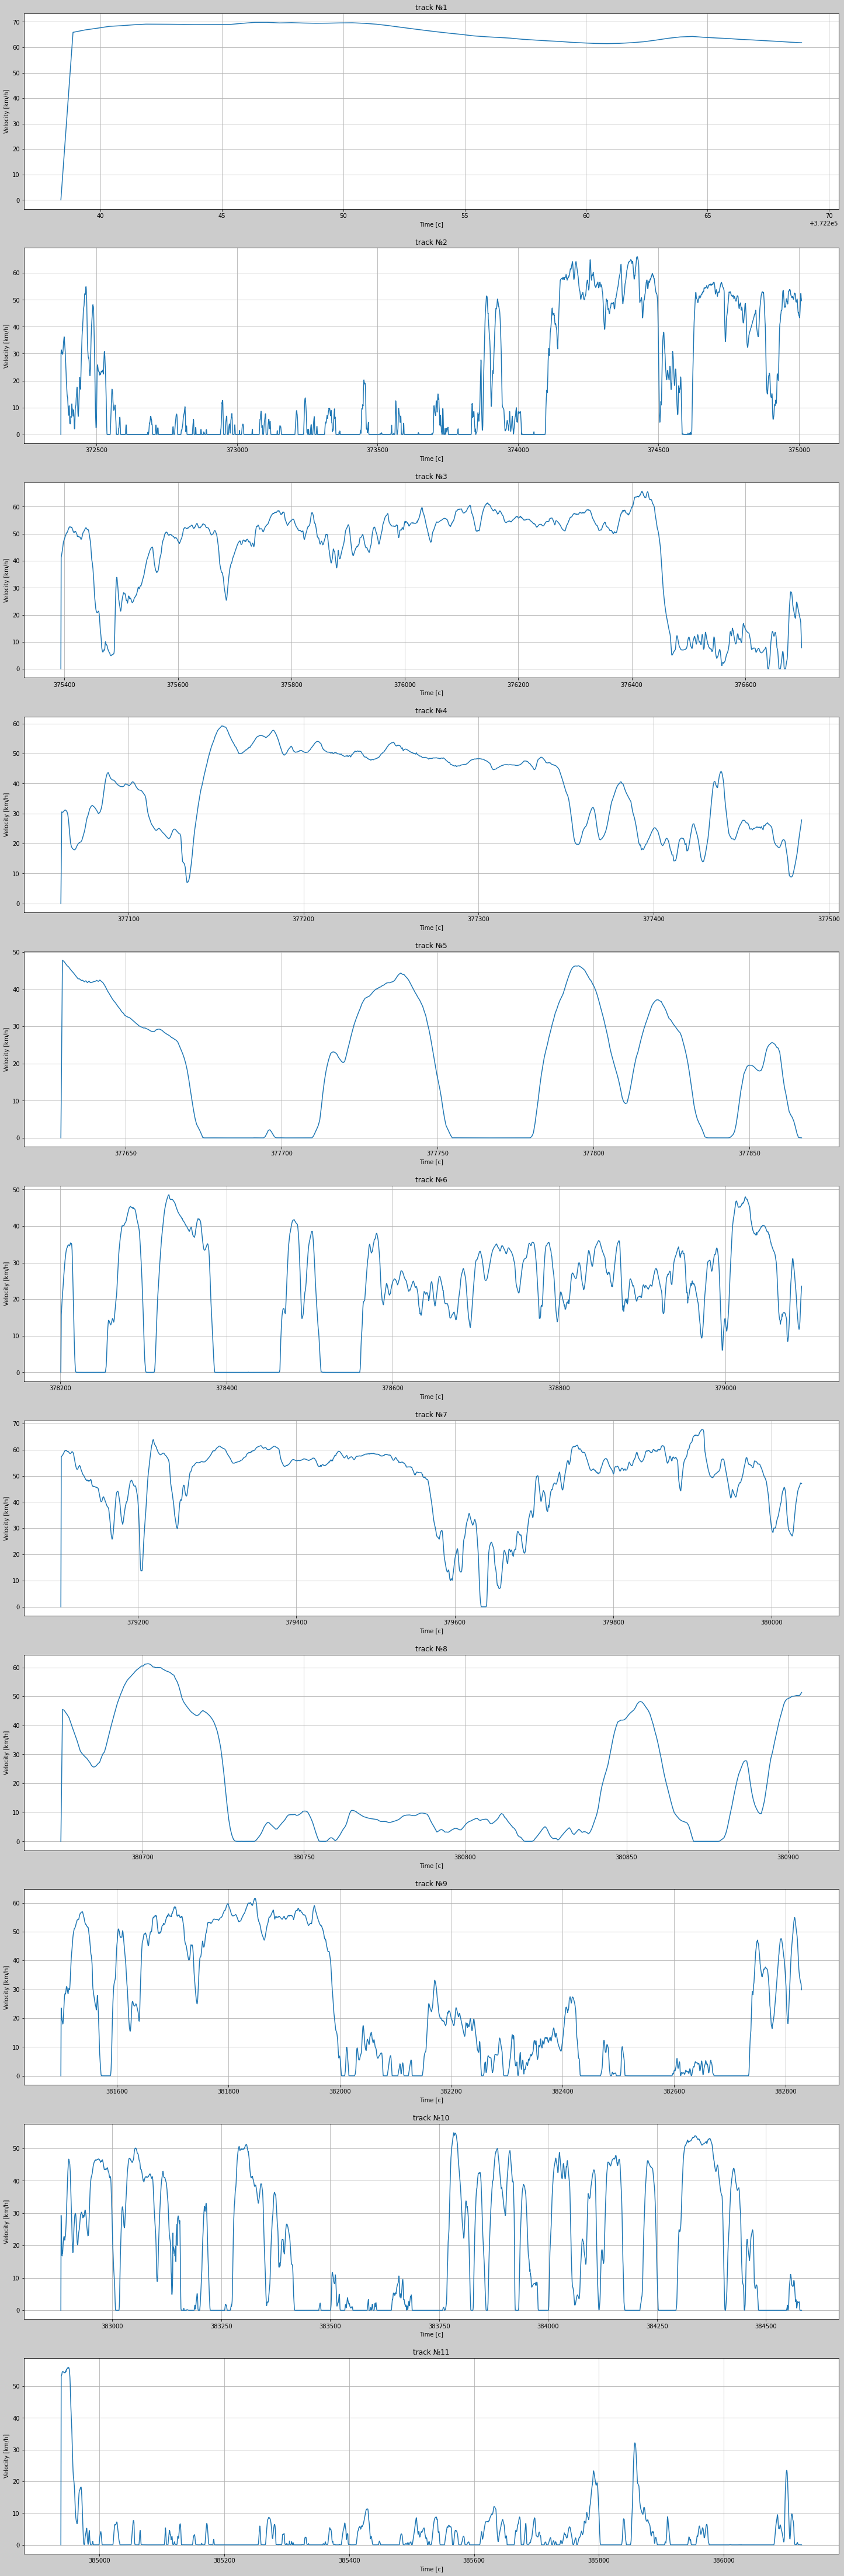

In [16]:
fig, ax = plt.subplots(data_split.shape[0],1)
fig.set_size_inches(25,80)
fig.set_facecolor((.8,.8,.8))

for i in range(data_split.shape[0]):
  ax[i].plot(data_split[i]["GPS time"], data_split[i]["velocity"])
  ax[i].set_title(f'track №{i+1}')
  ax[i].set_xlabel('Time [c]')
  ax[i].set_ylabel('Velocity [km/h]')
  ax[i].grid()

In [17]:
m.save("index.html")